<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/41_4_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from itertools import repeat

In [2]:
def DBL(x, filters, kernel, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm,  # используем смещение, если нет нормализации
              kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001)(x)
        x = LeakyReLU(negative_slope=0.1)(x)
    return x

In [3]:
def ResUnit(x, filters):
    skip_connection  = x
    x = DBL(x, filters // 2, 1)
    x = DBL(x, filters, 3)
    x = Add()([skip_connection , x])
    return x

In [4]:
def ResN(x, filters, blocks):
    x = DBL(x, filters, kernel=3, strides=2)
    for _ in repeat(None, blocks): # цикл по n-блокам (подход с repeat позволяет экономить память)
        x = ResUnit(x, filters)
    return x

In [5]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DBL(x, 32, 3)
    x = ResN(x, 64, 1)
    x = ResN(x, 128, 2)
    x = Route_1 = ResN(x, 256, 8)
    x = Route_2 = ResN(x, 512, 8)
    Route_3 = ResN(x, 1024, 4)
    return tf.keras.Model(inputs, (Route_1, Route_2, Route_3), name=name)

In [6]:
def YoloHead(filters, name=None):
    def layer(x_in):
        if isinstance(x_in, tuple): #
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DBL(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return layer

def YoloHeadOutput(filters, anchors, classes, name=None):
    def layer(x_in):

        x = inputs = Input(x_in.shape[1:])
        x = DBL(x, filters * 2, 3)
        x = DBL(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return layer

In [7]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [8]:
def yolo_boxes(pred, anchors, classes):
    # На входе pred размера (S, S, 3, (1+4+80))

    grid_size = tf.shape(pred)[1] # S ячеек в сетке

    # В box_xy и box_wh помещаем сразу по 2 переменные (tx, ty) и (tw, th)
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) # раскладываем предсказанную карту по переменным

    # Применяем сигмоидные функции
    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    # Построим сетку S x S
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    # Привяжем box_xy к ячейкам сетки, учтем смещения (и снова нормируем к диапазону 0, 1)
    # Фактически мы вычисляем центральное положение рамки относительно размеров сетки (якорного поля)
    b_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) # вычисляем b_xy: (bx, by)

    b_wh = tf.exp(box_wh) * anchors # вычисляем b_wh: (bw, bh), ширина и высота рамки bbox

    box_x1y1 = b_xy - b_wh / 2
    box_x2y2 = b_xy + b_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) # задаем рамку bbox, как 2 координаты углов

    return bbox, score, class_probs, pred_box

In [9]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    # Блок преобразования трех выходов разных масштабов
    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    # Конкатенируем три масштаба в один
    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs # Оценки считаем как произведение оценок объектности на вероятности классов

    # Применяем NMS из пакета tensorflow (работаем с документацией, смотрим параметры самостоятельно: https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=YOLO_IOU_THRESHOLD,
        score_threshold=YOLO_SCORE_THRESHOLD)

    return boxes, scores, classes, valid_detections

In [10]:
YOLO_IOU_THRESHOLD = 0.6 # порог для оценок перекрытия IOU в NMS (параметр iou_threshold в tf.image.combined_non_max_suppression)
YOLO_SCORE_THRESHOLD = 0.6 # порог для оценок scores применяется в NMS (параметр score_threshold в tf.image.combined_non_max_suppression)

WEIGHT_YOLO_V3 = 'yolov3.weights' # путь к файлу с предобученными весами
SIZE = 416 # изменяем изображения до размеров
CHECKPOINTS = 'yolov3.weights.h5' # путь сохранения весов модели
NUM_CLASSES = 80 # число классов, на которых обучена модель

In [11]:
!wget https://storage.yandexcloud.net/academy.ai/CV/yolov3.weights

--2025-02-23 05:50:00--  https://storage.yandexcloud.net/academy.ai/CV/yolov3.weights
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/x-www-form-urlencoded]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  14.3MB/s    in 27s     

2025-02-23 05:50:28 (8.68 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [12]:
YOLO_V3_LAYERS = [
    'yolo_darknet',
    'yolo_head_1',
    'yolo_output_1',
    'yolo_head_2',
    'yolo_output_2',
    'yolo_head_3',
    'yolo_output_3']

In [13]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    # Вход
    x = inputs = Input([size, size, channels])

    # Модель Darknet с тремя выходами
    Route_1, Route_2, Route_3 = Darknet(name='yolo_darknet')(x)

    # Определяем 3 головы с разным числом фильтров
    x = YoloHead(512, name='yolo_head_1')(Route_3)
    output_0 = YoloHeadOutput(512, len(masks[0]), classes, name='yolo_output_1')(x)

    x = YoloHead(256, name='yolo_head_2')((x, Route_2))
    output_1 = YoloHeadOutput(256, len(masks[1]), classes, name='yolo_output_2')(x)

    x = YoloHead(128, name='yolo_head_3')((x, Route_1))
    output_2 = YoloHeadOutput(128, len(masks[2]), classes, name='yolo_output_3')(x)

    if training: # заложим модель для обучения (понадобиться в домашней работе)
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Перегоняем предсказанные якорные рамки в boundary box для трех выходов
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    # Отсекаем все лишнее алгоритмом NMS
    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3') # возвращаем модель для инференса

In [14]:
def load_darknet_weights(model, weights_file):

    wf = open(weights_file, 'rb') # загружаем файл

    # Читаем из файла по элементам (первые 5, версия файла)
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS # слои для загрузки

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)      # извлекаем блоки слоев из модели по имени
        for i, layer in enumerate(sub_model.layers): # пробегаемся по отдельным слоям блоков
            if not layer.name.startswith('conv2d'):  # пропускаем не сверточные слои
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]  # фиксируем если за слоем будет батч-нормализация

            filters = layer.filters                   # фильтров в слое
            size = layer.kernel_size[0]               # размер ядра в слое
            #in_dim = layer.input_shape[-1]           # input_shape в слоях Conv2d больше не поддерживается
            in_dim = layer.get_weights()[0].shape[2]  # входная размерность слоя

            # Вспоминаем структуру DBL: если нет нормализации, то добавляется смещение
            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters) # считываем веса для смещения
            else:
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4*filters) # считываем веса для нормализации
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]     # меняем форму

            conv_shape = (filters, in_dim, size, size)    # размерности сверточного слоя
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.prod(conv_shape))  # считываем веса для сверточного слоя
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0]) # меняем форму данных весов, решейпим и транспонируем

            # Если нет нормализации, то добавляем веса + смещение
            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                # Если есть нормализации, то добавляем веса в сверточный слой и в следующий за ним слой нормализации
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read weights'   # генерируем исключение, если файл не читается
    wf.close()

In [15]:
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1 # координаты начала и конца первого отрезка
    x3, x4 = interval_2 # координаты начала и конца второго отрезка
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

In [16]:
def intersectionOverUnion(box1, box2): # box1, box2 - координаты рамки
    intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area # возвращает значение IoU

In [17]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):

        # 1. Преобразуем все предсказанные выходы
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        # с функцией yolo_boxes мы уже знакомы
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. Преобразуем все реальные значения
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # Чем меньше рамка, тем больше ошибка
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. Инвертируем  уравнений красного прямоугольника inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        # 4. Вычисляем ignore_mask
        obj_mask = tf.squeeze(true_obj, -1)
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(intersectionOverUnion(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. Вычисляем все функции ошибок
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        # Можно использовать как binary_crossentropy, так и sparse_categorical_crossentropy
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. Все функции ошибок суммируются по осям для каждого пакета (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        # Общая суммарная ошибка
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [18]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())

def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs) # [x, y, w, h, obj, class]

def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

In [19]:
def draw_outputs(img, outputs, class_names, white_list=None):
    boxes, score, classes, nums = outputs # распознанные объекты
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2]) # предсказанные ширина и высота
    for i in range(nums):
        # Отображаем объекты только из white_list
        if class_names[int(classes[i])] not in white_list:
            continue

        # Предсказанные координаты нижнего левого и правого верхнего углов
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

        # Рисуем прямоугольник по двум предсказанным координатам
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 1)

        # Выводим имя класса предсказанного объекта и оценку
        img = cv2.putText(img, '{} {:.2f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 1)
    return img

In [20]:
def detect_objects(img_path, white_list=None):
    image = img_path # путь к файлу
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3) # загружаем изображение как тензор

    img = tf.expand_dims(img, 0) # добавляем размерность
    img = preprocess_image(img, SIZE) # ресайзим изображение
    boxes, scores, classes, nums = yolo.predict(img) # делаем предсказание

    img = cv2.imread(image) # считываем изображение как картинку, чтобы на нем рисовать
    # Отрисовываем на картинке предсказанные объекты
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list)

    # Сохраняем изображения с предсказанными объектами
    cv2.imwrite('detected_{:}'.format(img_path), img)

    # Открываем сохраненные изображения и выводим на экран
    detected = Image.open('detected_{:}'.format(img_path))
    detected.show()
    plt.imshow(detected)

In [32]:
# yolo = YoloV3(classes=NUM_CLASSES)

# load_darknet_weights(yolo, WEIGHT_YOLO_V3)

# yolo.save_weights(CHECKPOINTS)

# class_names =  ["white king", "white queen", "white rook", "white bishop", "white knight", "white pawn",
#                 "black king", "black queen", "black rook", "black bishop", "black knight", "black pawn",
#                 "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
#                 "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis",
#                 "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
#                 "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
#                 "bowl", "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
#                 "donut", "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor",
#                 "laptop", "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
#                 "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
yolo = YoloV3(classes=NUM_CLASSES)
load_darknet_weights(yolo, WEIGHT_YOLO_V3)
yolo.save_weights(CHECKPOINTS)

In [ ]:
class_names =  ["white king", "white queen", "white rook", "white bishop", "white knight", "white pawn",
                "black king", "black queen", "black rook", "black bishop", "black knight", "black pawn",
                "banana","apple"]

In [33]:
!wget https://storage.yandexcloud.net/academy.ai/CV/hqdefault.jpg

--2025-02-23 06:05:55--  https://storage.yandexcloud.net/academy.ai/CV/hqdefault.jpg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13790 (13K) [image/jpeg]
Saving to: ‘hqdefault.jpg.1’

hqdefault.jpg.1     100%[===================>]  13.47K  --.-KB/s    in 0s      

2025-02-23 06:05:56 (143 MB/s) - ‘hqdefault.jpg.1’ saved [13790/13790]



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


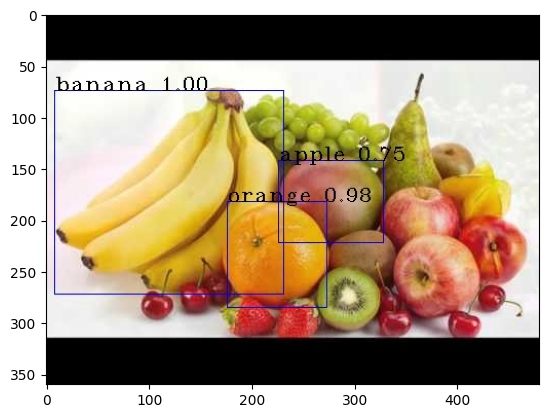

In [34]:
detect_objects('hqdefault.jpg', class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


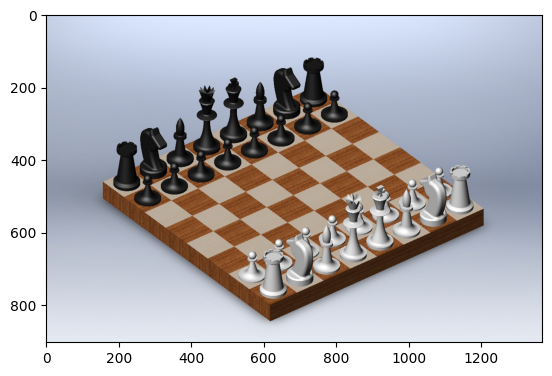

In [35]:
detect_objects('chess-1.jpg', class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


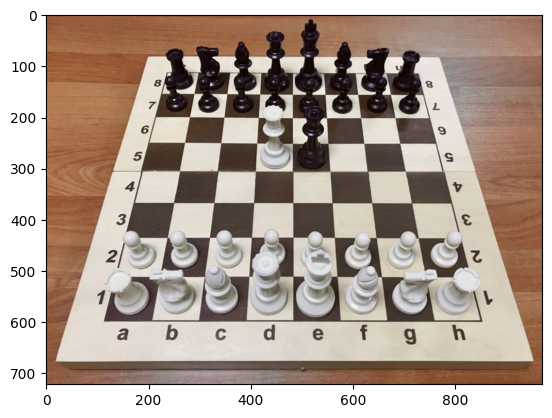

In [36]:
detect_objects('chess-2.jpg', class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


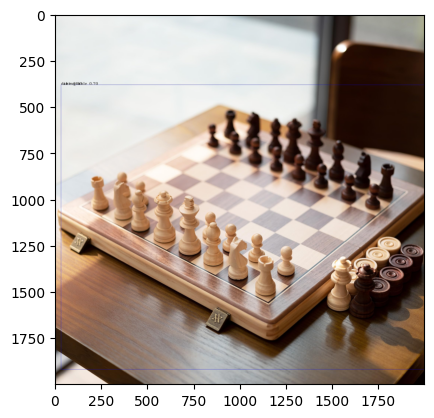

In [37]:
detect_objects('chess-3.jpg', class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


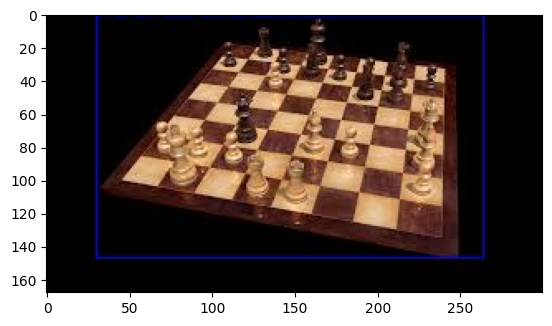

In [38]:
detect_objects('chess-4.jpeg', class_names)